In [1]:
%load_ext autoreload
%autoreload 2

# Intro

Welcome to the BlendingToolKit (BTK) quickstart! This tutorial will guide you through the basic functionalities of BTK. If you are new to BTK, we recommend you to go through this notebook before moving on to the other tutorials.

We will show you how to generate a catalog of galaxy blends, draw images of these blends, use algorithms implemented within BTK to deblend these images, and finally use metrics within BTK to assess the performance of the deblender.

# Setup

First, we will need to import the relevant python packages and modules:

In [2]:
%matplotlib inline
import numpy as np
from tqdm import tqdm 

In [3]:
import btk
import btk.survey
import btk.draw_blends
import btk.catalog
import btk.sampling_functions

In [4]:
btk.__path__

['/home/g4merz/.conda/envs/btknv/lib/python3.9/site-packages/btk']

# Drawing Blends

Before generating images of blends, we require some setup. 

**First**, we need to specify a catalog of galaxies to draw. We will use a subset of the CATSIM catalog, which contains `100` galaxies with realistic parameters.

BTK uses a wrapper class (e.g. `btk.catalog.CatsimCatalog`) to store information about the galaxy catalog you pass in. You can easily import the CATSIM catalog from a FITS file using the `from_file` method as demonstrated here with our example catalog:

In [5]:
catalog_name = "../data/input_catalog.fits" # contains ~85k entries
catalog = btk.catalog.CatsimCatalog.from_file(catalog_name)
catalog.table[:5] # display 5 first entries of table containing the actual catalog information.

galtileid,ra,dec,redshift,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,a_b,a_d,b_b,b_d,pa_bulge,pa_disk,u_ab,g_ab,r_ab,i_ab,z_ab,y_ab
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2200871446,0.418319702147,-0.000148399994941,0.496377289295,0.0,1.4144730572e-17,0.0,0.0,0.278649687767,0.0,0.221303001046,0.0,307.344329834,25.9418621063,25.129743576,23.9588813782,23.3607368469,23.0723800659,22.9095973969
2205921112,0.420028448104,-0.00100259995088,1.89508104324,0.0,1.91501907101e-18,0.0,0.0,0.358063697815,0.0,0.313674807549,0.0,137.791702271,25.848903656,25.867565155,25.9179477692,25.9851398468,25.8779563904,25.7642536163
2205010878,0.423432350157,-0.00312969996594,1.93795013428,0.0,2.15612608955e-18,0.0,0.0,0.444279909134,0.0,0.424689114094,0.0,233.972427368,25.5657653809,25.5659580231,25.6165962219,25.6957893372,25.6281528473,25.5399188995
2208734677,0.42108619213,-7.25999998394e-05,1.16251754761,0.0,1.74001598433e-18,0.0,0.0,0.312852591276,0.0,0.180962398648,0.0,217.517120361,27.3159255981,27.4167633057,27.051820755,26.6737632751,25.9380722046,25.6458129883
2212241881,0.423181056976,-0.00218109996058,1.35479903221,0.0,1.11031595423e-18,0.0,0.0,0.414316505194,0.0,0.205554202199,0.0,226.523849487,27.3325939178,27.4470024109,27.3282527924,27.0680370331,26.7419490814,26.1817016602


**Second**, we require specifying a *sampling function*. The sampling function is a custom class within BTK that is used to determine which galaxies are drawn for each blend and what their locations within the blend should be. 

Specifically, we implement this functionality with the `SamplingFunction` class, which is a `callable` like a function. It takes as argument the astropy table contained within the `Catalog` object above, selects galaxies to be drawn in a given blend, and returns their (possibly modified) entries. Usually the `ra` and `dec` columns of these entries are modified to be relative to the center of the postage stamp containing the blend. 

For this tutorial, we will use the *default sampling function*, this function is implemented in the `btk.sampling_functions` module and is called `DefaultSampling`. This function draws a random number of galaxies from the catalog, uniformly distributed between 1 and `max_number`, and places them randomly within the postage stamp with some maximum shift `max_shift` w.r.t the center of the postage stamp.

The `DefaultSampling` function can be instantiated as follows:

In [6]:
stamp_size = 24.0  # Size of the stamp, in arcseconds
max_number = 3    # Maximum number of galaxies in a blend
max_shift = 1.0    # Maximum shift of the galaxies, in arcseconds
seed = 0 # random seed for reproducibility purposes # seed = 8
sampling_function = btk.sampling_functions.DefaultSampling(
    max_number=max_number, min_number=max_number,  # always get `max_number` galaxies
    stamp_size=stamp_size, max_shift=max_shift, 
    min_mag = 24, max_mag = 25,
    seed = seed)

Here is an example output of the `DefaultSampling` function:

In [7]:
blend_catalog = sampling_function(catalog.table)
blend_catalog # ra and dec are now relative to the center of the blend (not the original ones)

galtileid,ra,dec,redshift,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,a_b,a_d,b_b,b_d,pa_bulge,pa_disk,u_ab,g_ab,r_ab,i_ab,z_ab,y_ab
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
402702752470,-0.9180529521276106,0.8255111545554434,1.63697004318,0.0,9.98907691776e-18,0.0,0.0,0.275980591774,0.0,0.119993202388,0.0,349.267944336,25.1750850677,25.1185207367,25.1801185608,24.8593482971,24.6722679138,24.3998889923
402701798070,-0.9669447289429418,0.21327155153435973,1.3657746315,4.04416795735e-19,1.44999699035e-17,0.0,0.118003599346,0.459019094706,0.085155300796,0.267128199339,300.030426025,300.030426025,24.319562912,24.4032745361,24.3106765747,24.0974407196,23.8517131805,23.3093605042
402702992522,0.6265404784005448,0.4589931219679968,2.60180902481,1.21744196986e-19,3.68331408574e-18,0.0,0.115780897439,0.603495299816,0.111025497317,0.535213828087,163.053985596,163.053985596,25.1713447571,24.8985767365,24.9358558655,24.9527740479,25.0367050171,25.0126132965


**Third**, we need to specify a *survey*. This will determine the pixel scale, sky level, and PSF of the images we will draw. 

BTK relies on the [galcheat](https://github.com/aboucaud/galcheat) package, which contains several `galcheat.survey.Survey` instances, which store the parameters for different surveys (including LSST, HSC, HST COSMOS...). The parameters represent physical parameters of the survey (mirror size, pixel scale). Each survey also contains several `galcheat.filter.Filter` objects with the parameters specific to each filter (exposure time, zeropoint). 

In BTK, we use the `btk.survey.Survey` class to store the survey parameters. This class is a simple wrapper around the `galcheat.survey.Survey` class, and contains additional information such as the PSF model.

For this tutorial, we will import the survey corresponding to LSST.

In [8]:
LSST = btk.survey.get_surveys("LSST")

You can see the parameters of the survey by printing the `Survey` object:

In [9]:
print(LSST)

--------
| LSST | Legacy Survey of Space and Time (LSST) done with the Simonyi survey telescope and the LSST camera
--------
  pixel_scale          = 0.2 arcsec
  mirror_diameter      = 8.36 m
  gain                 = 1.0 electron / adu
  obscuration          = 0.39257227
  zeropoint_airmass    = 1.2
  available_filters    = ['u', 'g', 'r', 'i', 'z', 'y']
  effective_area       = 33.342414830068996 m2


**Finally**, now that we have finished our setup, we can create the `DrawBlendsGenerator`. This object is a python `generator`, meaning it can be called with `next(generator)` to generate a new batch of blend catalogs and images. 

The `DrawBlendsGenerator` takes as arguments the `Catalog` object, the `SamplingFunction` object, and the `Survey` object. It also takes a few other arguments, such as the number of images to draw per batch, the size of the postage stamps, and the number of galaxies to draw per blend.

In [10]:
batch_size = 100

draw_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    sampling_function,
    LSST,
    batch_size=batch_size,
    stamp_size=stamp_size,
    njobs=1,
    add_noise="all",
    seed=seed, # use same seed here
)

# generate batch 100 blend catalogs and images.
blend_batch = next(draw_generator)

The output of the `DrawBlendsGenerator` is a class called `BlendBatch`, which contains the truth catalogs, simulated blends, and isolated images (among other metadata). 

For example to access the images of blends, we can use the following syntax:

In [11]:
blend_batch.blend_images.shape 
# shape = (batch_size, n_bands, stamp_size, stamp_size)

(100, 6, 120, 120)

The truth catalogs are contained in the `catalog_list` object which is a list of catalogs, one per each blend in the batch. In total there are `batch_size` blends in the batch.

In [12]:
blend_batch.catalog_list[0] 
# blend_list is a list of astropy tables, one for each blend in the batch.

galtileid,ra,dec,redshift,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,a_b,a_d,b_b,b_d,pa_bulge,pa_disk,u_ab,g_ab,r_ab,i_ab,z_ab,y_ab,x_peak,y_peak,btk_rotation,not_drawn_u,not_drawn_g,not_drawn_r,not_drawn_i,not_drawn_z,not_drawn_y
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2203000845,0.8701448475755365,0.7148085531751387,2.57267403603,6.3268708269e-18,1.54905100017e-18,1.80331302741e-20,1.00473165512,0.0965721979737,0.832231402397,0.0207626000047,246.150009155,246.150009155,25.0703849792,24.7873039246,24.7652378082,24.7562961578,24.8058547974,24.6890239716,63.850724237965,63.07404276606157,0.0,0.0,0.0,0.0,0.0,0.0,0.0
402702985871,0.6317071082430643,-0.9328288493890713,2.65117931366,3.54715891614e-18,2.51396090702e-18,0.0,0.348030596972,0.0783303007483,0.346858501434,0.0157197006047,79.9261322021,79.9261322021,25.5836200714,24.9703712463,24.8542499542,24.9327831268,24.9444885254,24.8123722076,62.6585355410587,54.83585575315076,0.0,0.0,0.0,0.0,0.0,0.0,0.0
402702901687,-0.9945229996597038,0.45931089285988813,0.773414492607,0.0,6.44347310117e-18,0.0,0.0,0.118766099215,0.0,0.0432423986495,0.0,314.817993164,26.6721954346,26.2752513885,25.6849498749,24.8465938568,24.542634964,24.3480949402,54.52738500140222,61.79655446439899,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There is also additional information which you can inspect by printing the `BlendBatch` object. Specifically, the PSF and WCS. The PSF is a list of `galsim.GSObject` objects, one per filter, and the WCS is an astropy `WCS` object.

In [13]:
blend_batch

BlendBatch(survey_name=LSST, 
	 blend_images: np.ndarray, shape [100, 6, 120, 120]
	 isolated_images: np.ndarray, shape [100, 3, 6, 120, 120]
	 catalog_list: list of <class 'astropy.table.table.Table'>, size 100
	 psfs: list of <class 'galsim.gsobject.GSObject'>, size 6
	 wcs: <class 'astropy.wcs.wcs.WCS'>)

We can proceed to display a given blend using `matplotlib`:

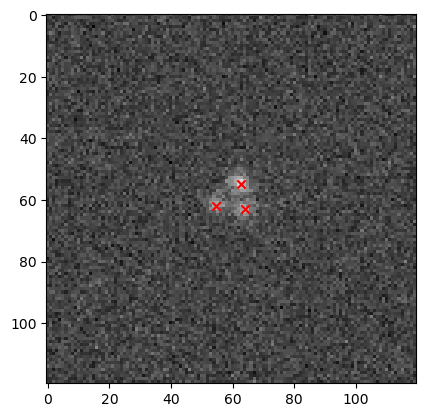

In [14]:
import matplotlib.pyplot as plt

# plot the first blend in the batch, with the r-band
plt.imshow(blend_batch.blend_images[0, 2, :, :], cmap="gray")

# plot centers
plt.scatter(blend_batch.catalog_list[0]["x_peak"], 
            blend_batch.catalog_list[0]["y_peak"], c="r", marker="x")

We can use the function from `astropy` to plot in RGB (see [documentation](https://docs.astropy.org/en/stable/api/astropy.visualization.make_lupton_rgb.html) here for more info):

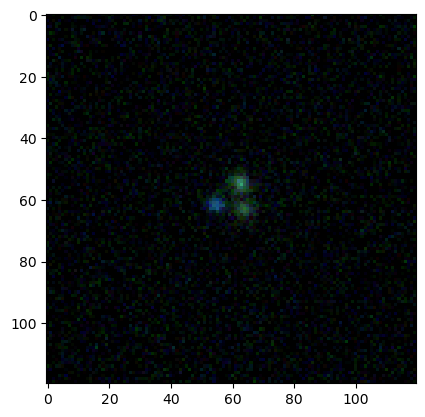

In [15]:
from astropy.visualization import make_lupton_rgb

im = blend_batch.blend_images[0]
bands = [1, 2, 3] # g, r, i 
stretch = np.max(im) - np.min(im)
Q = 0.1

img_rgb = make_lupton_rgb(im[bands[0]], im[bands[1]], im[bands[2]], stretch=stretch, Q=Q)
plt.imshow(img_rgb)

Or our own BTK utility function which uses a linear stretch:

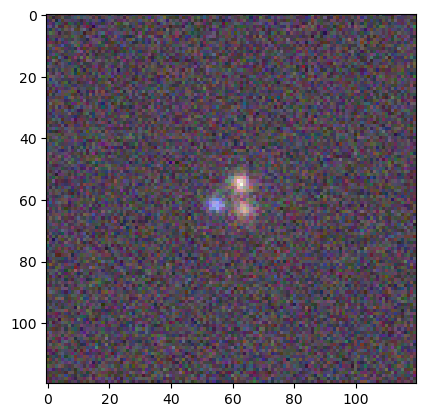

In [16]:
from btk.plotting import get_rgb

rgb = get_rgb(im[bands])
plt.imshow(rgb)

# Deblending

The next big part of BTK is the deblending. We will use the `Deblender` class to deblend the images we just drew. By 'deblending' we mean that we want to recover the individual galaxies that were blended together in the images. This includes recovering their positions, fluxes, and shapes.

In this tutorial we will use the `SExtractor` deblender, which is implemented in the `btk.deblender` module. Specifically the class `SepSingleband` is a wrapper around the [SEP](https://sep.readthedocs.io/en/v1.1.x/) package, which is a python implementation of the [SExtractor](https://www.astromatic.net/software/sextractor) algorithm that performs detection on a single band.

Here is how we create the `Deblender` object:

In [17]:
from btk.deblend import SepSingleBand

In [18]:
deblender = SepSingleBand(max_n_sources=3, # same as above
                          thresh=3, # threshold pixel value for detection (see SEP docs)
                          use_band=2 # measure on 'r' band
                          )

You can use the `Deblender` object to deblend the images we drew earlier. The `Deblender` object takes as input the `BlendBatch` object, and returns a new `DeblenderBatch` object with the deblended images and/or catalogs.

In [19]:
output = deblender.deblend(0, blend_batch) # deblend the first blend in the batch.

Let's inspect the output which is a `DeblendedExample` object. The output contains at least a `catalog` attribute, which in this case contains the locations for the deblended objects in the first blend of the batch.

In [20]:
print(output)

DeblendExample(max_n_sources = 3, n_bands = 1, image_size = 120), 
 containing: 
	catalog: <class 'astropy.table.table.Table'>
	segmentation: <class 'numpy.ndarray'>, shape [3, 120, 120]
	deblended_images: <class 'numpy.ndarray'>, shape [3, 1, 120, 120]


In [21]:
output.catalog

ra,dec,x_peak,y_peak
float64,float64,float64,float64
0.5827758848773104,-0.9066195821690349,62.41387942457128,54.966902088769075
1295999.059118221,0.43823668932150206,54.79559110564468,61.69118344654811
0.8111213907827577,0.7218396466069961,63.55560695402137,63.1091982330916


There is also an option to run the deblender on the full batch with the `__call__` method of any `Deblender` object. This method takes as input the `BlendBatch` object, and returns a new `DeblenderBatch` object with the deblended images and catalogs for each blend in the batch.

In [22]:
deblend_batch = deblender(blend_batch, njobs=1) # deblend the whole batch

You can access them as attributes of the `DeblenderBatch` object:

In [23]:
deblend_batch.catalog_list[0] # predicted catalog for the first blend in the batch

ra,dec,x_peak,y_peak
float64,float64,float64,float64
0.5827758848773104,-0.9066195821690349,62.41387942457128,54.966902088769075
1295999.059118221,0.43823668932150206,54.79559110564468,61.69118344654811
0.8111213907827577,0.7218396466069961,63.55560695402137,63.1091982330916


Let's compare the results from both the truth catalog and predicted catalog.

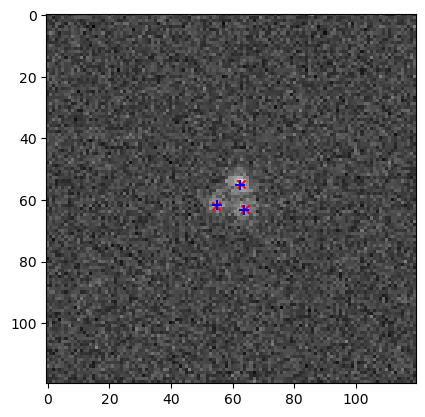

In [24]:
import matplotlib.pyplot as plt

# plot the first blend in the batch, with the r-band
plt.imshow(blend_batch.blend_images[0, 2, :, :], cmap="gray")

# plot centers of truth
plt.scatter(blend_batch.catalog_list[0]["x_peak"], blend_batch.catalog_list[0]["y_peak"], c="r", marker="x")

# plot centers of prediction

# need to use wcs to convert ra and dec to x and y
x, y = deblend_batch.catalog_list[0]['x_peak'], deblend_batch.catalog_list[0]['y_peak']
plt.scatter(x, y, c="b", marker="+", s=50)

We can also inspect the deblended images and compare with the isolated ones. 

**Note:** Images do not necessarily line up in general as below, need to match (see next section)

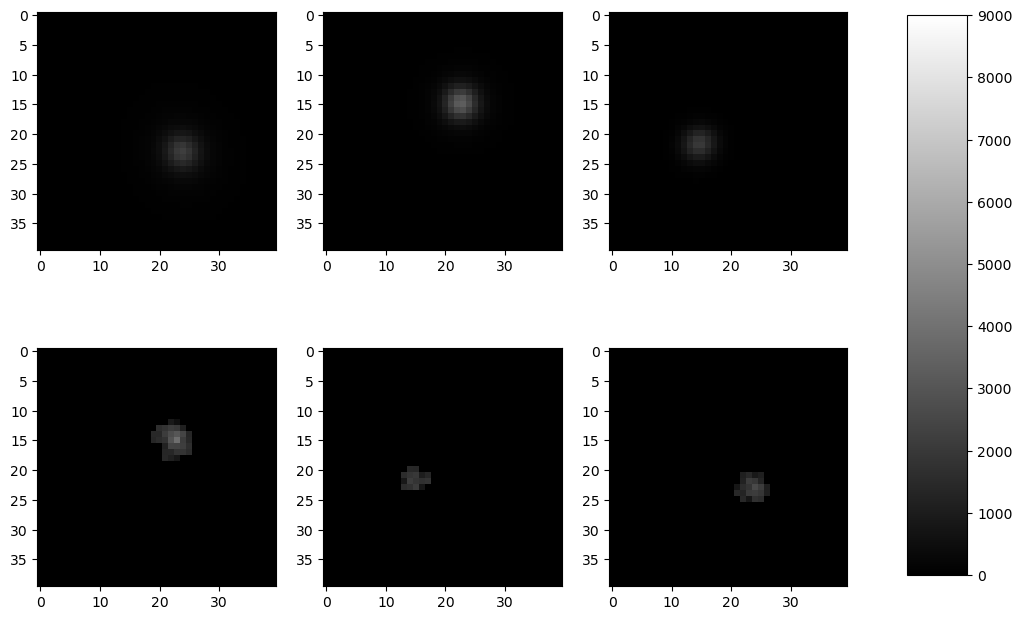

In [25]:
# plot isolated images from truth 
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

clip = 40 # zoom into images

true_images = blend_batch.isolated_images[0, :, 2, clip:-clip, clip:-clip]
pred_images = deblend_batch.deblended_images[0, :, clip:-clip, clip:-clip] # only contains r-band

# use global vmin and vmax
vmin = 0
vmax = 9000

for ii in range(3):
    ax = axes.flatten()[ii]
    ax.imshow(blend_batch.isolated_images[0, ii, 2, clip:-clip, clip:-clip], cmap="gray", 
              vmin=vmin, vmax=vmax)

# plot isolated images from prediction
for ii in range(3, 6):
    ax = axes.flatten()[ii]
    ax.imshow(deblend_batch.deblended_images[0, ii-3, 0, clip:-clip, clip:-clip], cmap="gray", 
              vmin=vmin, vmax=vmax)

# add colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(axes[0, 0].imshow(blend_batch.isolated_images[0, 0, 2, clip:-clip, clip:-clip], cmap="gray", vmin=vmin, vmax=vmax), cax=cbar_ax)

# Matching

To be able to compare the predictions of each deblender to the truth or to other deblenders we need to match the predicted catalogs to the truth catalogs. This is done using the `Matcher` class.

We have implemented several matching algorithms in the `btk.match` module. For this tutorial we will use the `PixelHungarianMatcher` matcher, which uses the Hungarian algorithm to perform the matching.

In [26]:
from btk.match import PixelHungarianMatcher

In [27]:
matcher = PixelHungarianMatcher(pixel_max_sep=5.0 # maximum separation to consider match, in pixels
)

Before matching, we need to add pixel centroids to the catalogs of `deblend_batch`. As it currently only contains `ra` and `dec`. We can do it easily with the utility function `btk.utils.add_pixel_columns`:

In [28]:
deblend_batch.catalog_list[0].colnames # no x_peak, y_peak

['ra', 'dec', 'x_peak', 'y_peak']

In [29]:
# matchers operate on `catalog_lists`, so we need to extract them from our batch classes. 
true_catalog_list = blend_batch.catalog_list
pred_catalog_list = deblend_batch.catalog_list
matching = matcher(true_catalog_list, pred_catalog_list) # matching object

The matching object contains useful information (for a given batch...): 

In [30]:
(matching.true_matches[0], # index of each true source that is matched with predicted 
 matching.pred_matches[0], #index of each pred source that is matched with truth
   matching.n_true[0],  # number of truth total
   matching.n_pred[0],  # number of predicted total 
)

(array([0, 1, 2]), array([2, 0, 1]), 3, 3)

We can already do something useful, like compute average separation between matched predictions on the batch (in pixels)

In [31]:
# first we match the catalogs so that all objects between catalogs are aligned
matched_true_catalogs = matching.match_true_catalogs(true_catalog_list)
matched_pred_catalogs = matching.match_pred_catalogs(pred_catalog_list)

In [32]:
# now compute distances on each catalog and average
dist = [] # list of distances between matched objects
for true_cat, pred_cat in zip(matched_true_catalogs, matched_pred_catalogs):
    if len(true_cat) == 0 or len(pred_cat) == 0:
        continue
    x1, y1 = true_cat['x_peak'], true_cat['y_peak']
    x2, y2 = pred_cat['x_peak'], pred_cat['y_peak']
    dist.append(np.sqrt( (x1-x2)**2 + (y1-y2)**2 ))
# unpack list of distances into a single array
dist = np.concatenate(dist)
np.mean(dist)

1.097238677748789

# Metrics

Now we show how to compute metrics, metrics in BTK are separated into three classes: **detection**, **segmentation**, and **reconstruction**. For this tutorial we will focus on computing `recall`, which is type of detection metric.

Metrics in BTK are designed to work on batches, every time a new batch is computed the metric update its state to accumulate the results of each batch. Creating a metric object to start accumulating results is simple, just pass in the `batch_size`:

## Detection

In [33]:
from btk.metrics.detection import Recall

In [34]:
recall = Recall(batch_size)

The detection type metrics specifically take in three arrays `n_matches` (equivalent to true-positives), `n_true`, and `n_pred`. These arrays can all be easily obtained from the `matching` object we computed above.

In [35]:
recall(matching.tp, matching.n_true, matching.n_pred)

0.4166666666666667

We can accumulate recalls over multiple batches to get a more accurate results (for our specific draw blend generator):

In [36]:
# get generator w/o bar for nicer output
draw_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    sampling_function,
    LSST,
    batch_size=batch_size,
    stamp_size=stamp_size,
    njobs=1,
    add_noise="all",
    seed=seed, # use same seed here
    use_bar=False
)

In [38]:
n_batches = 10
for n in tqdm(range(n_batches)):
    blend_batch = next(draw_generator)
    deblend_batch = deblender(blend_batch, njobs=1)
    true_catalog_list = blend_batch.catalog_list
    pred_catalog_list = deblend_batch.catalog_list
    matching = matcher(true_catalog_list, pred_catalog_list)
    recall(matching.tp, matching.n_true, matching.n_pred) # accumulate values internally

100%|██████████| 10/10 [01:19<00:00,  7.96s/it]


Multiple metrics can be computed for each batch to save time. For simplicity, just focusing on one metric.

Let's look at all the recall values obtained for each batch:

In [39]:
print(recall.values)

[0.4166666666666667, 0.44333333333333336, 0.41333333333333333, 0.4066666666666667, 0.42, 0.41333333333333333, 0.42333333333333334, 0.4266666666666667, 0.42333333333333334, 0.42333333333333334, 0.42333333333333334]


And we can compute the aggragate, which for this metric is just the mean of the recall values: 

In [40]:
recall.aggregate()

0.42121212121212115

## Reconstruction

In [41]:
from btk.metrics.reconstruction import MSE
mse = MSE(batch_size)

In [43]:
# for reconstruction and segmentation, need to match first and then apply metric
iso_images1 = blend_batch.isolated_images[:, :, 2] # only r-band
iso_images2 = deblend_batch.deblended_images[:, :, 0] 
iso_images_matched1 = matching.match_true_arrays(iso_images1)
iso_images_matched2 = matching.match_pred_arrays(iso_images2)

In [44]:
mse(iso_images_matched1, iso_images_matched2) # automatically accounts for empty arrays

93.56661845591279

# Measurement

Another useful quantity we can obtain are what in BTK we call 'measurements'. These are quantities that can be derived from galaxy images like aperture fluxes, ellipticities, or signal-to-noise ratio that might help you understand the performance of your algorithm.

BTK provides functions to easily compute these quantities from batches. For example, for SNR we have a `get_snr` function. It takes in the `isolated_images` inside `blend_batch` and the `sky_level` or background that can be easily computed. 

In [45]:
from galcheat.utilities import mean_sky_level
from btk.measure import get_snr

# we will continue using 'r' band
sky_level = mean_sky_level(LSST, 'r').to_value('electron') # gain = 1
iso_images = blend_batch.isolated_images[:,:, 2] # only r-band
snr = get_snr(iso_images, sky_level)
snr.shape # one for each source in each batch

(100, 3)

Histogram of SNRs for one batch: 

(array([17., 67., 95., 59., 37., 15.,  4.,  4.,  1.,  1.]),
 array([ 6.33130473, 13.43881672, 20.54632872, 27.65384071, 34.76135271,
        41.8688647 , 48.9763767 , 56.08388869, 63.19140069, 70.29891269,
        77.40642468]),
 [<matplotlib.patches.Polygon at 0x7ffe409066d0>])

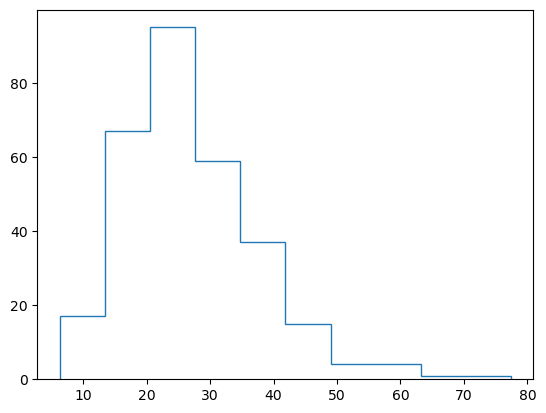

In [46]:
plt.hist(snr.flatten(), histtype='step')

We can also compare true ellipticity with deblended ellipticity (measured with KSB) easily for a single batch: 

In [47]:
from btk.measure import get_ksb_ellipticity

#obtaining images
iso_images1 = blend_batch.isolated_images[:,:, 2] # only r-band
psf_r =blend_batch.psf[2] # psf in r-band
iso_images2 = deblend_batch.deblended_images[:, :, 0] # select band

#matching
iso_images_matched1 = matching.match_true_arrays(iso_images1)
iso_images_matched2 = matching.match_pred_arrays(iso_images2)

#compute ellipticity
ellips1 = get_ksb_ellipticity(iso_images_matched1, psf_r, pixel_scale=0.2)

# NOTE: assumed deblended images are psf convolved with same psf
ellips2 = get_ksb_ellipticity(iso_images_matched2, psf_r, pixel_scale=0.2) 


# mask nan's (non-matches), look at first component only
e11 = ellips1[:, :, 0].flatten()
e12 = ellips2[:, :, 0].flatten()

mask = (~np.isnan(e12)) & (np.abs(e12) < 1) & (~np.isnan(e11))
e11 = e11[mask]
e12 = e12[mask]

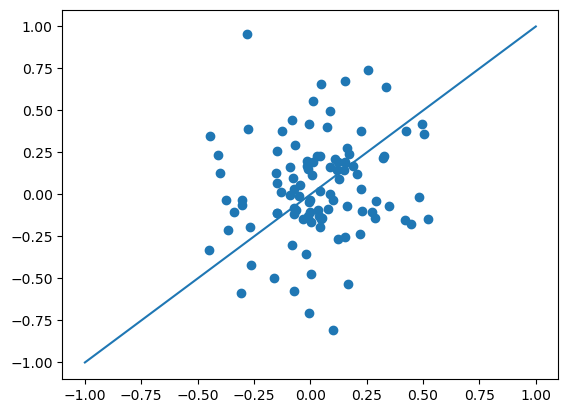

In [48]:
# look at first component 
plt.scatter(e11, e12)
plt.plot([-1, 1], [-1, 1])